In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn

/root/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = 'nlp_data/names/*.txt'

In [3]:
def findFiles(path):
    return glob.glob(path)

In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [5]:
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(file_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [9]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Seok
category = Vietnamese / line = Quyen
category = Czech / line = Marek
category = Dutch / line = Snider
category = Italian / line = Columbo
category = Korean / line = Ma
category = Vietnamese / line = Ton
category = Czech / line = Weichert
category = Dutch / line = Andel
category = Vietnamese / line = Le


In [10]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [11]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
n_iters = 100000
print_every = 5000
plot_every = 1000

In [14]:
current_loss = 0
all_losses = []

In [15]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 56s) 3.2263 Gwang  / Italian ✗ (Korean)
10000 10% (1m 55s) 2.9883 Pettigrew / Dutch ✗ (French)
15000 15% (2m 52s) 2.3140 Elmes / Dutch ✗ (English)
20000 20% (3m 50s) 1.2126 Ariwara / Japanese ✓
25000 25% (4m 48s) 1.3734 Bicchieri / Italian ✓
30000 30% (5m 46s) 1.5964 Heinrichs / German ✓
35000 35% (6m 45s) 1.2859 Ferguson / Scottish ✓
40000 40% (7m 43s) 0.9029 Chu / Vietnamese ✓
45000 45% (8m 41s) 0.6708 Ryom / Korean ✓
50000 50% (9m 39s) 1.6816 Gray / Scottish ✓
55000 55% (10m 37s) 0.0192 Nishimoto / Japanese ✓
60000 60% (12m 10s) 2.3154 Johnstone / Japanese ✗ (Scottish)
65000 65% (13m 44s) 0.2126 Amalberti / Italian ✓
70000 70% (15m 9s) 0.7002 Ha / Korean ✓
75000 75% (16m 53s) 1.8868 Obando / Italian ✗ (Spanish)
80000 80% (18m 31s) 2.9331 Kocian / Dutch ✗ (Czech)
85000 85% (20m 13s) 0.9485 Durant / French ✓
90000 90% (22m 18s) 0.6503 Ryoo / Korean ✓
95000 95% (23m 42s) 0.3780 Mui / Chinese ✓
100000 100% (24m 42s) 0.4835 Palmeiro / Portuguese ✓


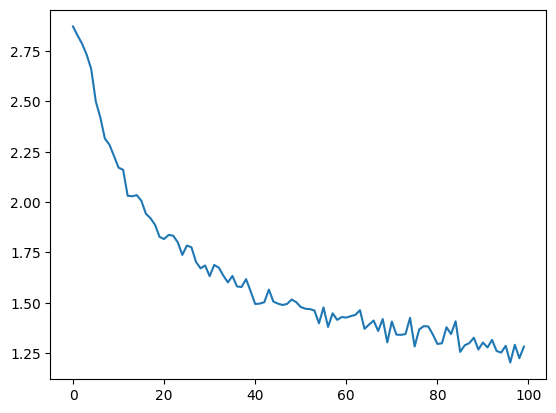

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [18]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [20]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [21]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.28) Russian
(-1.82) Czech
(-3.49) Polish

> Jackson
(-0.32) Scottish
(-1.47) English
(-4.15) Russian

> Satoshi
(-0.90) Arabic
(-1.01) Japanese
(-3.00) Italian


In [23]:
path = './nlp_data/rnn_vanilla.pt'
torch.save(rnn.state_dict(), path)

In [ ]:
# TODO
# lSTM 사용
# GPU 사용
# Adam optimizer 사용